In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime

import re
import nltk
from nltk.tokenize import word_tokenize 
nltk.download('stopwords')    

from sklearn.preprocessing import StandardScaler
from prince import PCA
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.regression import linear_model
from sklearn.model_selection import train_test_split

from scipy.stats import kruskal
!pip install scikit_posthocs
import scikit_posthocs as sp

# models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.dummy import DummyClassifier

# evaluation
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# visualization
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline
style.use('seaborn-white')
import seaborn as sns
sns.set_style('white')

!pip install jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme = 'onedork', grid = False)

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pharm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Prep
### Tweets Dataset

In [2]:
us_tweets = pd.read_csv('us_tweets.csv')
us_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178756 entries, 0 to 178755
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   status_id             178756 non-null  object 
 1   user_id               178751 non-null  object 
 2   created_at            178749 non-null  object 
 3   screen_name           178748 non-null  object 
 4   text                  178749 non-null  object 
 5   source                178749 non-null  object 
 6   reply_to_status_id    18579 non-null   object 
 7   reply_to_user_id      26427 non-null   float64
 8   reply_to_screen_name  26427 non-null   object 
 9   is_quote              178749 non-null  object 
 10  is_retweet            178749 non-null  object 
 11  favourites_count      178749 non-null  object 
 12  retweet_count         178749 non-null  float64
 13  country_code          178749 non-null  object 
 14  place_full_name       178747 non-null  object 
 15  

In [3]:
state_codes = list(pd.read_csv('states.csv').Abbreviation)

In [4]:
us_tweets = us_tweets[us_tweets.state.isin(state_codes)]

In [5]:
features = ['created_at', 'text', 'state', 'account_created_at', 'retweet_count', 'lang']
us_tweets = us_tweets[features]

Most of the tweets are English, but there are many other languages represented. I'll be filtering out non-English tweets

In [6]:
us_tweets.lang.value_counts().head()

en     134214
und      8048
es       4144
fr        328
pt        239
Name: lang, dtype: int64

In [7]:
us_english_tweets = us_tweets[us_tweets.lang == 'en']
len(us_english_tweets)

134214

Removing observations where the account was created the same day as the tweet.

In [8]:
us_english_tweets.sort_values('account_created_at', ascending=False)

,created_at,text,state,account_created_at,retweet_count,lang
169621,2020-04-30T19:45:15Z,"Reckless, Indifferent Walgreens employees enda...",NY,2020-04-30T19:34:03Z,1.0,en
169454,2020-04-30T18:49:18Z,She has sacrificed so much and has left such a...,CA,2020-04-30T17:54:06Z,0.0,en
169348,2020-04-30T18:24:02Z,@LaurentDTardif You’re a hero @LaurentDTardif ...,CA,2020-04-30T17:54:06Z,1.0,en
168585,2020-04-30T15:14:54Z,“Tweet Tweet Skeet Skeet” as they say? #famous...,OK,2020-04-30T15:06:38Z,0.0,en
167070,2020-04-30T01:25:02Z,#COVID19 @lapublichealth Is anyone else having...,CA,2020-04-30T01:04:42Z,0.0,en
...,...,...,...,...,...,...
43589,2020-04-12T17:25:23Z,Definitely a concern I had about the #coronavi...,CA,2006-07-16T06:53:48Z,2.0,en
83808,2020-04-10T19:37:34Z,#COVID19 tweets of the year? \n\nhttps://t.co/...,CA,2006-07-16T06:53:48Z,9.0,en
94582,2020-04-07T21:15:49Z,#TIL COVID-19 is short for COronaVIrus Disease...,CA,2006-07-16T06:53:48Z,2.0,en
10385,2020-04-09T15:52:42Z,How will we flatten this curve?\n\nhttps://t.c...,CA,2006-07-16T06:53:48Z,0.0,en


In [9]:
us_english_tweets.created_at = pd.to_datetime(us_english_tweets.created_at).dt.date
us_english_tweets.account_created_at = pd.to_datetime(us_english_tweets.account_created_at).dt.date
us_english_tweets[us_english_tweets.created_at != us_english_tweets.account_created_at]

,created_at,text,state,account_created_at,retweet_count,lang
0,2020-04-03,This is a reminder there is a lot of good in t...,AR,2008-12-11,0.0,en
1,2020-04-03,Putting in that work this evening with @snapfi...,VT,2013-05-31,0.0,en
2,2020-04-03,.@USEmbassyPH @hrw while we all appreciate the...,NY,2010-01-27,0.0,en
3,2020-04-03,@AC360 @drsanjaygupta This guy was on national...,IN,2013-04-21,0.0,en
4,2020-04-03,#COVID19 \n#Georgia 🍑\nHE PROBABLY THOUGHT THE...,OH,2019-07-29,0.0,en
...,...,...,...,...,...,...
178750,2020-04-28,Stop bailing out corporations! Start paying pe...,CA,2009-12-26,0.0,en
178752,2020-04-28,"6 beds, 7.5 baths, 5,673 sq ft...$4.195 millio...",CA,2011-06-07,0.0,en
178753,2020-04-28,Thank you merakitchencollective and @AlmaCocin...,MD,2009-03-22,0.0,en
178754,2020-04-28,Our new neighbors just moved here from NYC. Th...,TN,2009-05-21,0.0,en


In [10]:
us_english_tweets.drop(['lang', 'account_created_at'], axis=1)

,created_at,text,state,retweet_count
0,2020-04-03,This is a reminder there is a lot of good in t...,AR,0.0
1,2020-04-03,Putting in that work this evening with @snapfi...,VT,0.0
2,2020-04-03,.@USEmbassyPH @hrw while we all appreciate the...,NY,0.0
3,2020-04-03,@AC360 @drsanjaygupta This guy was on national...,IN,0.0
4,2020-04-03,#COVID19 \n#Georgia 🍑\nHE PROBABLY THOUGHT THE...,OH,0.0
...,...,...,...,...
178750,2020-04-28,Stop bailing out corporations! Start paying pe...,CA,0.0
178752,2020-04-28,"6 beds, 7.5 baths, 5,673 sq ft...$4.195 millio...",CA,0.0
178753,2020-04-28,Thank you merakitchencollective and @AlmaCocin...,MD,0.0
178754,2020-04-28,Our new neighbors just moved here from NYC. Th...,TN,0.0


Remove up some non-word tokens, such as hashtags and links

In [11]:
def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'RT[\s]+', '', text)
    text = re.sub(r'https?:\/\/\S+', '', text)
    text = re.sub(r'[\n]+', '', text)
    
    stopwords = nltk.corpus.stopwords.words('english')
    word_tokens = word_tokenize(text) 
    content = [w for w in word_tokens if w.lower() not in stopwords]
    
    return ' '.join(content)

In [12]:
us_english_tweets.text = us_english_tweets.text.astype(str).apply(clean_text)
us_english_tweets.head()

,created_at,text,state,account_created_at,retweet_count,lang
0,2020-04-03,reminder lot good world.An viewer pays rent wa...,AR,2008-12-11,0.0,en
1,2020-04-03,Putting work evening Vermont couple friends 💪🏻...,VT,2013-05-31,0.0,en
2,2020-04-03,. appreciate gravity covid19 unacceptable pres...,NY,2010-01-27,0.0,en
3,2020-04-03,guy national television sounding like idiot ! ...,IN,2013-04-21,0.0,en
4,2020-04-03,COVID19 Georgia 🍑HE PROBABLY THOUGHT REST WORL...,OH,2019-07-29,0.0,en


In [13]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
us_english_tweets = us_english_tweets.join(us_english_tweets.text
                                           .apply(lambda text: sid.polarity_scores(text))
                                           .apply(pd.Series))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\pharm\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [14]:
us_english_tweets.rename(columns={'compound' : 'sentiment'}, inplace=True)
us_english_tweets.sentiment.value_counts()

 0.0000    31431
 0.3612     2205
 0.4404     2016
 0.4019     1712
 0.3182     1392
           ...  
 0.1783        1
-0.1255        1
 0.9138        1
-0.2957        1
 0.6015        1
Name: sentiment, Length: 6891, dtype: int64

In [15]:
def calc_weighted_sentiment(row):
    if row.retweet_count == 0:
        return row.sentiment
    else:
        return row.sentiment * row.retweet_count

us_english_tweets['calc_weighted_sentiment'] = us_english_tweets.apply(calc_weighted_sentiment, axis=1)
us_english_tweets.drop(['retweet_count'], axis=1, inplace=True)

In [16]:
tweets_by_days = (us_english_tweets
                  .copy()
                  .groupby(['created_at', 'state'])
                  .mean())

tweets_by_state = (us_english_tweets
                   .copy()
                   .drop('created_at', axis=1)
                   .groupby(['state'])
                   .mean())

### COVID-19 Dataset

In [17]:
covid = pd.read_csv('us_states_covid19_daily.csv')
covid.info()
covid.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4273 entries, 0 to 4272
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      4273 non-null   int64  
 1   state                     4273 non-null   object 
 2   positive                  4258 non-null   float64
 3   negative                  4077 non-null   float64
 4   pending                   769 non-null    float64
 5   hospitalizedCurrently     1915 non-null   float64
 6   hospitalizedCumulative    1796 non-null   float64
 7   inIcuCurrently            1003 non-null   float64
 8   inIcuCumulative           411 non-null    float64
 9   onVentilatorCurrently     817 non-null    float64
 10  onVentilatorCumulative    138 non-null    float64
 11  recovered                 1744 non-null   float64
 12  dataQualityGrade          3160 non-null   object 
 13  lastUpdateEt              3912 non-null   object 
 14  hash    

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200520,AK,402.0,36643.0,NaN,16.0,NaN,NaN,NaN,NaN,...,NaN,37045,37045,37045,2,0.0,0.0,662.0,3.0,665.0
1,20200520,AL,12744.0,151706.0,NaN,NaN,1493.0,NaN,524.0,NaN,...,1493.0,164450,164450,164450,1,13.0,40.0,6516.0,368.0,6884.0
2,20200520,AR,5003.0,91255.0,NaN,78.0,535.0,NaN,NaN,14.0,...,535.0,96258,96258,96258,5,5.0,0.0,2477.0,80.0,2557.0
3,20200520,AS,0.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,124,124,124,60,0.0,0.0,0.0,0.0,0.0
4,20200520,AZ,14897.0,150538.0,NaN,810.0,1792.0,298.0,NaN,208.0,...,1792.0,165435,165435,165435,4,43.0,46.0,3533.0,331.0,3864.0


According to the dataset's self-reporting, most of the observations are considered to be of good quality.

In [18]:
covid.dataQualityGrade.value_counts()

A     1428
B     1011
C      345
A+     253
D       97
F       26
Name: dataQualityGrade, dtype: int64

In [19]:
covid[covid.dataQualityGrade.isin(['D', 'F'])].state.value_counts()

MP    26
AS    18
NE    18
NV    15
PR    15
GU    14
MD     7
MI     4
VI     4
OH     2
Name: state, dtype: int64

Many of the low-quality observations are from U.S. territories. Let's get rid of the low quality entries, since they aren't trustworthy.

In [20]:
covid = covid[covid.dataQualityGrade.isin(['A+', 'A', 'B', 'C'])]
covid.dataQualityGrade.value_counts()

A     1428
B     1011
C      345
A+     253
Name: dataQualityGrade, dtype: int64

It looks like there are quite a few null values. Let's get a clearer look.

In [21]:
covid.isnull().sum().sort_values(ascending=False)

onVentilatorCumulative      2899
pending                     2681
inIcuCumulative             2626
onVentilatorCurrently       2229
inIcuCurrently              2069
recovered                   1421
hospitalizedCumulative      1284
hospitalized                1284
hospitalizedCurrently       1182
death                         33
negative                      11
totalTestResultsIncrease       0
state                          0
positive                       0
lastUpdateEt                   0
dataQualityGrade               0
positiveIncrease               0
hash                           0
dateChecked                    0
total                          0
totalTestResults               0
posNeg                         0
fips                           0
deathIncrease                  0
hospitalizedIncrease           0
negativeIncrease               0
date                           0
dtype: int64

With the inconsistent reporting of COVID-19, it's likely there's data issues here. Without any easy way to identify incorrect null values, let's assume that null indicates a lack of reported cases and impute with 0

In [22]:
covid.fillna(0, inplace=True)
covid.isnull().sum().sort_values(ascending=False)

totalTestResultsIncrease    0
dataQualityGrade            0
state                       0
positive                    0
negative                    0
pending                     0
hospitalizedCurrently       0
hospitalizedCumulative      0
inIcuCurrently              0
inIcuCumulative             0
onVentilatorCurrently       0
onVentilatorCumulative      0
recovered                   0
lastUpdateEt                0
positiveIncrease            0
hash                        0
dateChecked                 0
death                       0
hospitalized                0
total                       0
totalTestResults            0
posNeg                      0
fips                        0
deathIncrease               0
hospitalizedIncrease        0
negativeIncrease            0
date                        0
dtype: int64

Let's remove the columns that we don't need.

In [23]:
covid.drop(['dataQualityGrade', 'lastUpdateEt', 'hash', 'dateChecked'], axis=1, inplace=True)

In [24]:
covid_by_days = (covid
                 .copy()
                 .groupby(['date', 'state'])
                 .mean())

covid_by_state = (covid
                  .copy()
                  .drop('date', axis=1)
                  .groupby(['state']).mean())

### Join the datasets

In [25]:
data_by_state = tweets_by_state.join(covid_by_state, lsuffix='_tweets', rsuffix='_covid', how='inner').reset_index()
data_by_days = tweets_by_days.join(covid_by_days, lsuffix='_tweets', rsuffix='_covid', how='inner').reset_index()

data_by_days['sentiment_class'] = data_by_days.sentiment.apply(lambda x: 0 if x == 0 else (1 if x > 0 else -1))

print(f'data_by_state: {len(data_by_state)}')
print(f'data_by_days: {len(data_by_days)}')

data_by_state: 51
data_by_days: 96026


## Data Exploration

In [26]:
data_by_days.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96026 entries, 0 to 96025
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   state                     96026 non-null  object 
 1   created_at                96026 non-null  object 
 2   date                      96026 non-null  int64  
 3   neg                       96026 non-null  float64
 4   neu                       96026 non-null  float64
 5   pos                       96026 non-null  float64
 6   sentiment                 96026 non-null  float64
 7   calc_weighted_sentiment   96026 non-null  float64
 8   positive                  96026 non-null  float64
 9   negative                  96026 non-null  float64
 10  pending                   96026 non-null  float64
 11  hospitalizedCurrently     96026 non-null  float64
 12  hospitalizedCumulative    96026 non-null  float64
 13  inIcuCurrently            96026 non-null  float64
 14  inIcuC

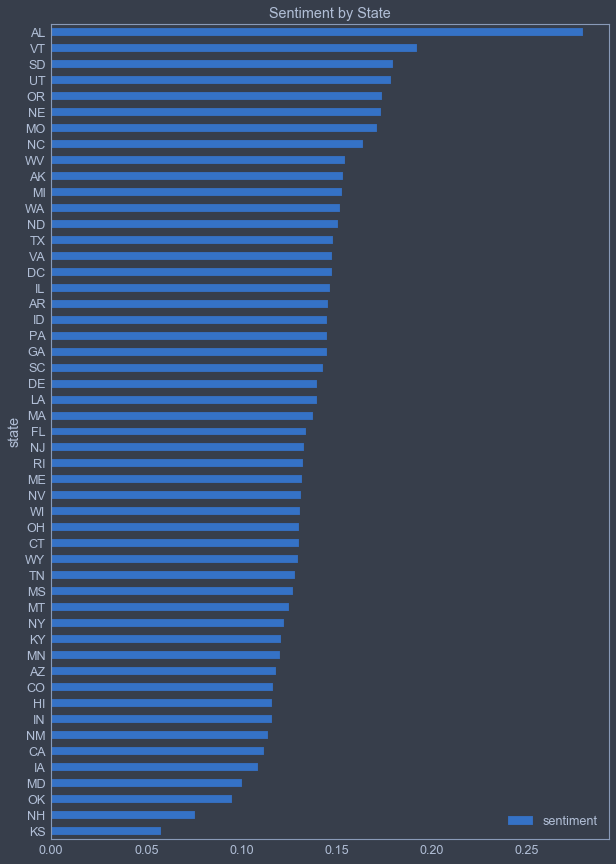

In [27]:
data_by_state.sort_values('sentiment').plot.barh(y='sentiment', x='state', figsize=(10,15), title='Sentiment by State')

In [28]:
sentiment_by_state = []
states = data_by_days.state.unique()
for state in states:
    sample = data_by_days[data_by_days.state == state].sample(100)
    sentiment_by_state.append(sample.sentiment)

In [29]:
sentiment_by_state[0]

1607    0.158200
220     0.115238
1733    0.311233
598     0.057860
1744    0.311233
          ...   
356     0.550312
609     0.057860
1398    0.524271
1260    0.473967
976     0.327600
Name: sentiment, Length: 100, dtype: float64

In [30]:
stat, p = kruskal(*sentiment_by_state)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=490.683, p=0.000
Different distributions (reject H0)


In [31]:
dunn = sp.posthoc_dunn(sentiment_by_state, p_adjust='holm')
dunn = pd.DataFrame(abs(dunn.mean(axis=0)), columns=['p'])
dunn.insert(0, 'state', states)
dunn.sort_values(by='p')

,state,p
2,AL,0.005464
31,NH,0.304890
1,AK,0.328167
17,KS,0.435127
25,MO,0.472721
38,OR,0.512364
37,OK,0.522759
5,CA,0.546732
21,MD,0.586079
45,UT,0.589583


In [32]:
data_by_days.copy()._get_numeric_data().drop(['date'], axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96026 entries, 0 to 96025
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   neg                       96026 non-null  float64
 1   neu                       96026 non-null  float64
 2   pos                       96026 non-null  float64
 3   sentiment                 96026 non-null  float64
 4   calc_weighted_sentiment   96026 non-null  float64
 5   positive                  96026 non-null  float64
 6   negative                  96026 non-null  float64
 7   pending                   96026 non-null  float64
 8   hospitalizedCurrently     96026 non-null  float64
 9   hospitalizedCumulative    96026 non-null  float64
 10  inIcuCurrently            96026 non-null  float64
 11  inIcuCumulative           96026 non-null  float64
 12  onVentilatorCurrently     96026 non-null  float64
 13  onVentilatorCumulative    96026 non-null  float64
 14  recove

In [33]:
df_by_days = data_by_days.copy()
print(f'Neutral Count: {df_by_days[df_by_days.sentiment_class == 0].sentiment_class.value_counts()}')
df_by_days = df_by_days[df_by_days.sentiment_class != 0]
y = df_by_days.sentiment_class
X = df_by_days._get_numeric_data().drop(['date', 'neg', 'neu', 'pos', 'sentiment', 'calc_weighted_sentiment', 'sentiment_class'], axis=1)

Neutral Count: 0    236
Name: sentiment_class, dtype: int64


No handles with labels found to put in legend.


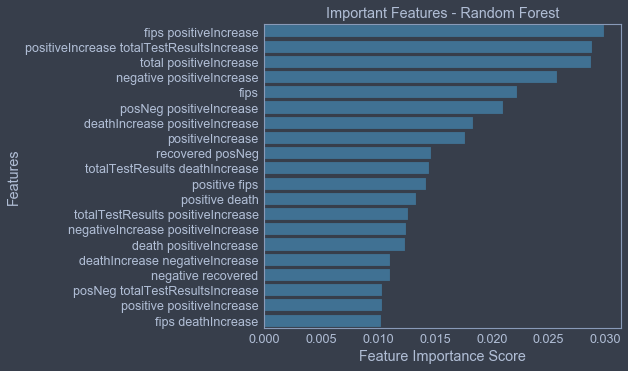

In [34]:
x_interaction = PolynomialFeatures(2, interaction_only=True, include_bias=False).fit(X)
interaction_df = pd.DataFrame(x_interaction.transform(X), columns = x_interaction.get_feature_names(X.columns))
interaction_model = linear_model.OLS(list(y), interaction_df).fit()

X = interaction_df

interaction_pvalues_05 = interaction_model.pvalues[interaction_model.pvalues < 0.05].sort_values(ascending=True)
interaction_features_05 = interaction_pvalues_05.index[:]

interaction_all = interaction_model.pvalues.sort_values(ascending=True)
interaction_features_05 = interaction_all.index[:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
clf = RandomForestClassifier(class_weight='balanced', 
                           n_estimators=100).fit(X_train,y_train)

feature_imp = pd.DataFrame(clf.feature_importances_, index=X.columns)
feature_imp = feature_imp[0].sort_values(ascending=False)

sns.barplot(x=feature_imp[:20], y=feature_imp[:20].index, color = '#3274A1')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Important Features - Random Forest")
plt.legend()
plt.show()

In [35]:
X_important = X[feature_imp[:50].index]

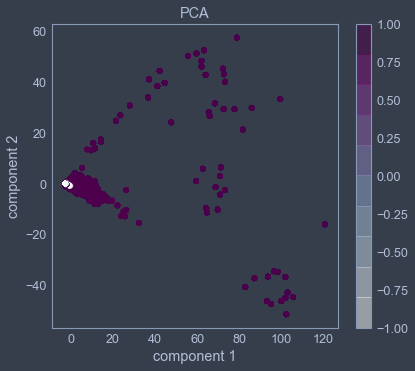

In [36]:
X_temp = X.copy()
scaler = StandardScaler()
scaler.fit(X_temp)
scaled_X = scaler.transform(X_temp)

pca = PCA(2) 
pca_X = pca.fit_transform(scaled_X)
plt.scatter(pca_X.iloc[:, 0], pca_X.iloc[:, 1],
            c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('BuPu', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('PCA')
plt.colorbar();

In [37]:
X_imputed = pca_X.copy()

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy= 'mean')

imputer = imputer.fit(X_imputed)
X_imputed = imputer.transform(X_imputed)

## Modeling

In [38]:
df_by_days

,state,created_at,date,neg,neu,pos,sentiment,calc_weighted_sentiment,positive,negative,...,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,sentiment_class
0,AK,2020-03-29,20200323,0.078714,0.7450,0.176286,0.203686,0.203686,22.0,946.0,...,968,968,968,2,0.0,0.0,0.0,0.0,0.0,1
1,AK,2020-03-29,20200324,0.078714,0.7450,0.176286,0.203686,0.203686,36.0,986.0,...,1022,1022,1022,2,0.0,0.0,40.0,14.0,54.0,1
2,AK,2020-03-29,20200325,0.078714,0.7450,0.176286,0.203686,0.203686,42.0,1649.0,...,1691,1691,1691,2,1.0,1.0,663.0,6.0,669.0,1
3,AK,2020-03-29,20200326,0.078714,0.7450,0.176286,0.203686,0.203686,59.0,1801.0,...,1860,1860,1860,2,0.0,2.0,152.0,17.0,169.0,1
4,AK,2020-03-29,20200327,0.078714,0.7450,0.176286,0.203686,0.203686,69.0,2319.0,...,2401,2388,2388,2,0.0,0.0,518.0,10.0,528.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96021,WY,2020-04-30,20200516,0.254500,0.7045,0.040500,-0.579850,-0.579850,716.0,15678.0,...,16394,16394,16394,56,0.0,1.0,371.0,1.0,372.0,-1
96022,WY,2020-04-30,20200517,0.254500,0.7045,0.040500,-0.579850,-0.579850,754.0,16331.0,...,17085,17085,17085,56,1.0,1.0,653.0,38.0,691.0,-1
96023,WY,2020-04-30,20200518,0.254500,0.7045,0.040500,-0.579850,-0.579850,754.0,16331.0,...,17085,17085,17085,56,0.0,3.0,0.0,0.0,0.0,-1
96024,WY,2020-04-30,20200519,0.254500,0.7045,0.040500,-0.579850,-0.579850,766.0,17084.0,...,17850,17850,17850,56,2.0,0.0,753.0,12.0,765.0,-1


In [39]:
y[y == 1] = 0
y[y == -1] = 1
print(y.value_counts())

0    87707
1     8083
Name: sentiment_class, dtype: int64


In [40]:
# model_params = {
#     'logistic_regression': {
#         'model': LogisticRegression(class_weight = 'balanced', max_iter=1000),
#         'params': {
#             'C': range(1, 20)
#         }
#     },
#     'random_forest': {
#         'model': RandomForestClassifier(class_weight = 'balanced'),
#         'params': {
#             'max_depth': range(1, 15),
#             'n_estimators': range(1, 50)
#         }
#     },
#     'k_nearest': {
#         'model': KNeighborsClassifier(),
#         'params': {
#             'n_neighbors': range(1, 10),
#             'leaf_size': range(1, 10)
#         }
#     }
# }

# scores = []

# from sklearn.model_selection import RandomizedSearchCV

# print('AUC')
# for model_name, mp in model_params.items():
#     clf = RandomizedSearchCV(mp['model'], mp['params'], scoring = 'roc_auc', return_train_score = False)
#     clf.fit(X, y)
#     scores.append({
#         'model': model_name,
#         'best_auc_score': clf.best_score_,
#         'best_params': clf.best_params_
#     })

# print('\nRecall')
# for model_name, mp in model_params.items():
#     clf = RandomizedSearchCV(mp['model'], mp['params'], scoring = 'recall', return_train_score = False)
#     clf.fit(X, y)
#     scores.append({
#         'model': model_name,
#         'best_recall_score': clf.best_score_,
#         'best_params': clf.best_params_
#     })


In [41]:
# scores

In [42]:
def create_confusion_matrix(y_test, y_pred, predicted_proba, title):
    cf_matrix = confusion_matrix(y_test, y_pred)

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    plt.title(title +  
              '\nRecall ' + str(round(recall_score(y_test, y_pred), 2)) +
              '\nPrecision ' + str(round(precision_score(y_test, y_pred), 2)) + 
              '\nAUC ' + str(round(roc_auc_score(y_test, predicted_proba[:,1]), 2)) +
              '\nF1 ' + str(round(f1_score(y_test, y_pred), 2)) +
              '\nAccuracy ' + str(round(accuracy_score(y_test, y_pred), 2)))
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

def create_model(model, X, y, title): 
    predicted_proba = cross_val_predict(model, X, y, method='predict_proba')
    y_pred = (predicted_proba[:,1] >= 0.3).astype('int')
    create_confusion_matrix(y, y_pred, predicted_proba, title)

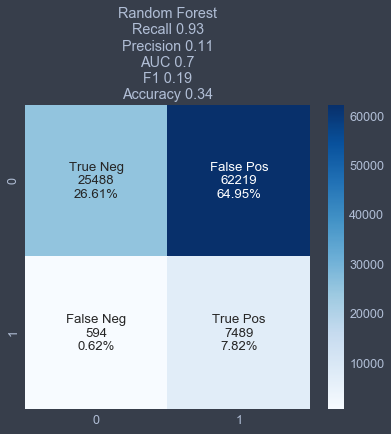

In [43]:
rf = RandomForestClassifier(class_weight='balanced', 
                               max_depth=3, 
                               n_estimators=50)

create_model(rf, X[feature_imp[:100].index], y, 'Random Forest')

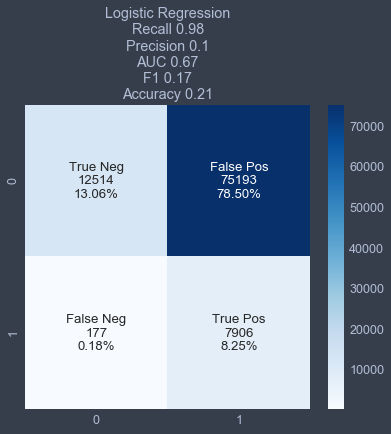

In [44]:
lr = LogisticRegression(class_weight='balanced', 
                        C=10,
                        max_iter=1000)

predicted_proba = cross_val_predict(lr, X_imputed, y, cv=5, method='predict_proba')
y_pred = (predicted_proba[:,1] >= 0.3).astype('int')
create_confusion_matrix(y, y_pred, predicted_proba, 'Logistic Regression')

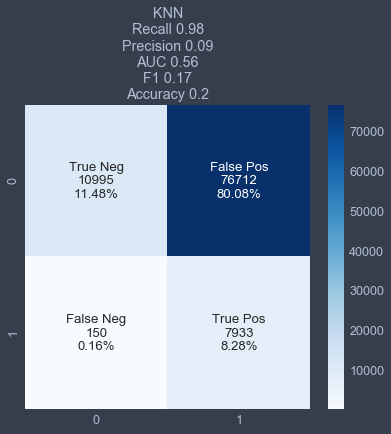

In [47]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
predicted_proba = cross_val_predict(model, X[feature_imp[:100].index], y, cv=5, method='predict_proba')
y_pred = (predicted_proba[:,1] >= 0.3).astype('int')
create_confusion_matrix(y, y_pred, predicted_proba, 'KNN')

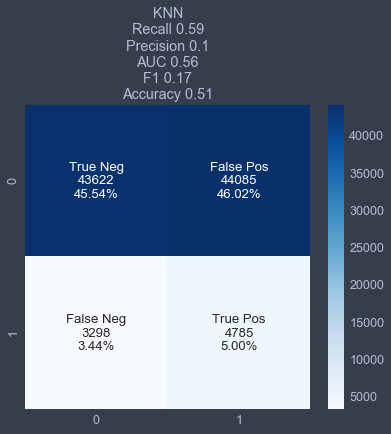

In [45]:
neigh = KNeighborsClassifier(n_neighbors=10)

predicted_proba = cross_val_predict(neigh, X[feature_imp[:100].index], y, cv=5, method='predict_proba')
y_pred = (predicted_proba[:,1] >= 0.1).astype('int')
create_confusion_matrix(y, y_pred, predicted_proba, 'KNN')

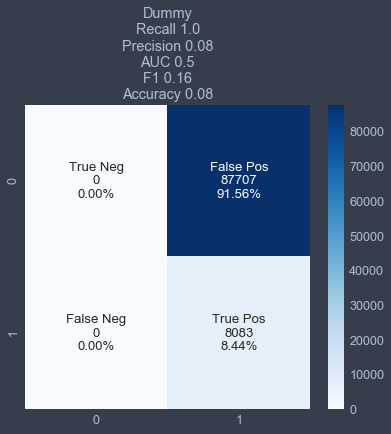

In [46]:
dummy_clf = DummyClassifier(strategy="uniform")
predicted_proba = cross_val_predict(dummy_clf, X[feature_imp[:100].index], y, cv=5, method='predict_proba')
y_pred = (predicted_proba[:,1] >= 0.5).astype('int')
create_confusion_matrix(y, y_pred, predicted_proba, 'Dummy')